In [14]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

rocs = []

with Chem.SDMolSupplier('rocs_out.sdf') as sdfh:
    rocs.extend(sdfh)
for i in range(2, 6):
    with Chem.SDMolSupplier(f'rocs_out{i}.sdf') as sdfh:
        rocs.extend(sdfh)

In [15]:
len(rocs)

2500

In [18]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, BRICS
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import pandera.typing as pdt
from typing import List, Dict
import pyrosetta
import pyrosetta_help as ph
from types import ModuleType

prc: ModuleType = pyrosetta.rosetta.core
prp: ModuleType = pyrosetta.rosetta.protocols
prn: ModuleType = pyrosetta.rosetta.numeric
prcc: ModuleType = pyrosetta.rosetta.core.conformation
pr_scoring: ModuleType = pyrosetta.rosetta.core.scoring
pr_simple: ModuleType = prp.simple_moves
pr_rsele: ModuleType = prc.select.residue_selector
    
# ------------------------------------------------------
    
import logging
import pyrosetta_help as ph
import pyrosetta

logger = ph.configure_logger()
logger.handlers[0].setLevel(logging.ERROR)  # logging.WARNING = 30
extra_options = ph.make_option_string(no_optH=False,
                                      ex1=None,
                                      ex2=None,
                                      #mute='all',
                                      ignore_unrecognized_res=True,
                                      load_PDB_components=False,
                                      ignore_waters=True)
pyrosetta.init(extra_options=extra_options)

## ====================================================

# crude filtering via PyRosetta.
# does it affect the masked score (10Å radius of Cys).

from rdkit import Geometry

def mol2pose(mol: Chem.Mol) -> pyrosetta.Pose:
    """
    Given an rdkit mol w/ a conformer make a PyRosetta pose w/ those coordinates
    """
    params = Params.from_mol(mol, name='LIG')
    # params.to_pose() is an ideal pose.
    #params.add_residuetype(pose)
    pose = params.to_pose()
    conf = params.mol.GetConformer()
    for atom in params.mol.GetAtoms():
        name = atom.GetPDBResidueInfo().GetName()
        pos: Geometry.Point3D = conf.GetAtomPosition(atom.GetIdx())
        xyz = prn.xyzVector_double_t(pos.x, pos.y, pos.z)
        pose.residue(1).set_xyz(name, xyz)
    return pose

def get_radius_score(pose, radius=10) -> float:
    cys_idx = pose.pdb_info().pdb2pose(chain='A', res=147)
    assert pose.residue(cys_idx).name3() == 'CYS'
    neigh_sele = pr_rsele.NeighborhoodResidueSelector(pr_rsele.ResidueIndexSelector(cys_idx),
                                                     radius,
                                                      True
                                                     )
    # scorefxn = pyrosetta.get_fa_scorefxn()
    # # clashes go away...
    # scorefxn.set_weight(pr_scoring.ScoreType.fa_rep, 0)
    # scorefxn(pose) # dummy call or segfault!
    return scorefxn.get_sub_score(pose, neigh_sele.apply(pose))



from rdkit_to_params import Params


def is_good(hit, apo):
    """
    
    """
    try:
        holo = apo.clone()
        lig_pose = mol2pose(hit)
        holo.append_pose_by_jump(lig_pose, holo.num_jump()+1)
        return get_radius_score(holo) - get_radius_score(apo) < -1
    except Exception as error:
        if 'CONN1' not in str(error):
            print(error.__class__.__name__, error)
        return False

PyRosetta-4 2023 [Rosetta PyRosetta4.Release.python310.m1 2023.16+release.942c01d5066fd96860b7d268702b832fe906a739 2023-04-12T15:05:51] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [29]:
with open('../reference.pdb') as fh:
    pdbblock = fh.read()
apo = pyrosetta.Pose()
prc.import_pose.pose_from_pdbstring(apo, pdbblock)
scorefxn = pyrosetta.get_fa_scorefxn()
# unaltered:
print(pr_scoring.ScoreType.fa_rep, scorefxn.get_weight(pr_scoring.ScoreType.fa_rep))

apo_score = scorefxn(apo)

good_rocs = []
bombed_rocs = []
for mol in rocs:
    mol.SetProp('_Name', mol.GetProp('id'))
    holo = apo.clone()
    try:
        lig_pose = mol2pose(mol)
        holo.append_pose_by_jump(lig_pose, holo.num_jump()+1)
        score = scorefxn(holo)
        mol.SetDoubleProp('Score', score - apo_score)
        if score - apo_score < 0: # scorefxn(lig_pose) is zero... ish...
            good_rocs.append(mol)
    except Exception as error:
        mol.SetProp('issue', f'{error.__class__.__name__}: {error}')
        bombed_rocs.append(mol)

ScoreType.fa_rep 0.55



ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/main/source/src/core/conformation/util.cc line: 1512

ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/main/source/src/core/conformation/util.cc line: 1512

ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/main/source/src/core/conformation/util.cc line: 1512

ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/main/source/src/core/conformation/util.cc line: 1512

ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/main/source/src/core/conformation/util.cc line: 1512

ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/main/source/src/core/conformation/util.cc line: 1512

ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/main/source/src/core/conformation/util.cc line: 1512

ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/main/source/src/core/conformation/util.cc line: 1512

ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/main/source/src/core/conformation/util.cc line: 1512

ERROR:: Exit from: /Volumes

In [31]:
len(bombed_rocs), len(good_rocs)

(27, 121)

In [54]:
with Chem.SDWriter('okay-rocs.sdf') as sdfh:
    for mol in good_rocs:
        sdfh.write(mol)

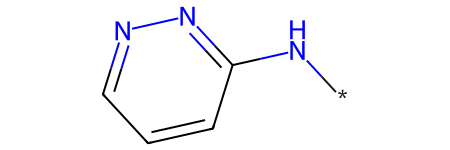

In [51]:
mol = Chem.MolFromSmiles('c1ccnnc1N*')
mol

In [52]:
mol = AllChem.AddHs(mol)

In [53]:
Chem.MolFromSmarts(Chem.MolToSmarts(mol))
Chem.MolToSmarts(mol)

'[#6]1(:[#6](:[#6](:[#7]:[#7]:[#6]:1-[#7](-[#0])-[H])-[H])-[H])-[H]'

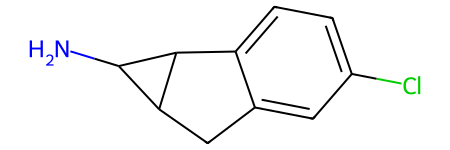

In [46]:
Chem.MolFromSmiles('NC1C2CC=3C=C(Cl)C=CC3C12')

In [56]:
bromine_zahl = 35
bromine: Chem.Atom = next(mol.GetAtomsMatchingQuery(Chem.rdqueries.AtomNumEqualsQueryAtom(bromine_zahl)))
mod = Chem.RWMol(mol)
mod.RemoveAtom(idx)
Chem.MolToSmarts( mod.GetMol() )

In [58]:
hits

NameError: name 'hits' is not defined